In [96]:
# imports
from copy import deepcopy
import numpy as np
from statistics import mean

import sys
sys.path.append('../src/')

from classification import get_stumps, get_scipy_selected_stumps
from evaluation import central_train_accuracy, central_test_accuracy, edges, central_loss, kalo_objective
from network import null_graph, get_alphas
from related_works import alternating_colearning
from optimization import gd_reg_local_FW, local_FW, global_regularized_local_FW, centralized_FW
from utils import load_harws, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
# set graph of nodes with local personalized data
NB_ITER = 500
n = 1122

MU = 10
BETA = 1

X, Y, X_test, Y_test, K, max_nb_instances = load_harws(path="../datasets/")
D = X[0].shape[1]

# get nodes
nodes = null_graph(X, Y, X_test, Y_test, K, max_nb_instances)

# set monitors for optimization analysis
monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
#     'edges': [edges, []]
}

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D, min_v=vmin, max_v=vmax)

results = {}

In [98]:
centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["global l1 Adaboost"] = {}
results["global l1 Adaboost"]["train-accuracy"] = central_train_accuracy(centralized_nodes)
results["global l1 Adaboost"]["test-accuracy"] = central_test_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["purely local models"] = {}
results["purely local models"]["train-accuracy"] = central_train_accuracy(local_nodes)
results["purely local models"]["test-accuracy"] = central_test_accuracy(local_nodes)

In [99]:
results["personalized linear gd"], clf_colearning = alternating_colearning(K, X, Y, X_test, Y_test, D, NB_ITER, 
    mu=0.1, la=1000, pace_gd=10, max_samples_per_node=max_nb_instances, checkevery=1)

In [100]:
MU, LA = 0.001, 100
STEP = 10

monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
    'edges': [edges, []],
    'obj-function': [kalo_objective, [MU, LA]],
}

gd_nodes = deepcopy(nodes)

results["Dada"] = gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"kalo", "pace_gd": STEP, 
    "args":(MU, LA)}, beta=BETA, mu=MU, nb_iter=NB_ITER, monitors=monitors, checkevery=1)

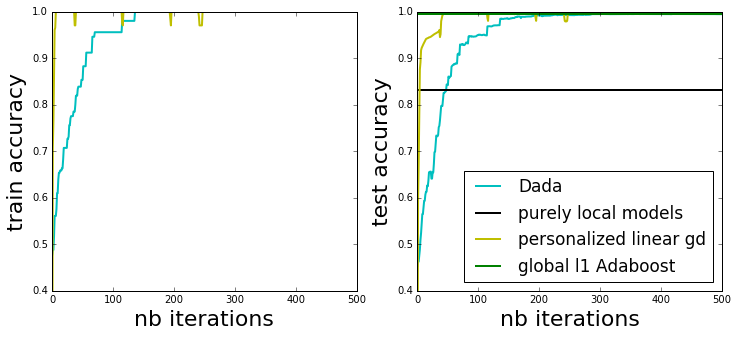

In [101]:
plt.figure(1, figsize=(12, 5))

colors = {
    "global l1 Adaboost": "g",
    "purely local models": "k",
    "personalized linear gd": "y", 
    "Dada": "c",
    "global-local mixture": "y",
}

max_iter = NB_ITER
plt.subplot(121)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('train accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 1)

for k, r_list in results.items():
    try:
        plt.plot([i for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label='_nolegend_', color=colors[k], linewidth=2)
    except:
        plt.plot(range(max_iter+1), [r_list['train-accuracy']]*(max_iter+1), label='{}'.format(k), color=colors[k], linewidth=2)
# plt.legend(loc='lower right', fontsize=17)


plt.subplot(122)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 1)

for k, r_list in results.items():
    try:
        plt.plot([i for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label=k, color=colors[k], linewidth=2)
    except:
        plt.plot(range(max_iter+1), [r_list['test-accuracy']]*(max_iter+1), label=k, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=17)
# plt.legend(bbox_to_anchor=(1.6, 1), fontsize=18)

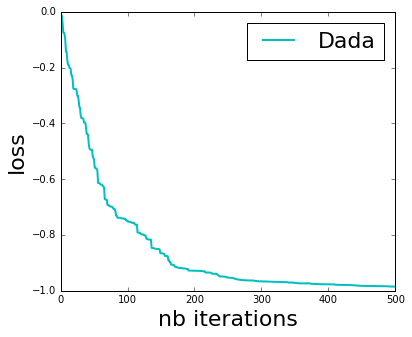

In [102]:
# convergence

max_iter = NB_ITER
plt.figure(1, figsize=(6, 5))

plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('loss', fontsize=22)

for k, r_list in results.items():
    try:
        plt.plot([i for i in range(len(r_list))], [r['loss'] for r in r_list], label='{}'.format(k), color=colors[k], linewidth=2)
    except:
        pass

plt.legend(loc='upper right', fontsize=22)

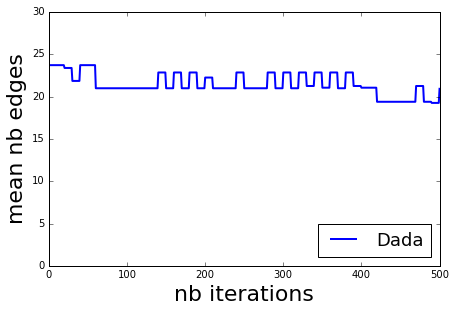

In [103]:
max_iter = NB_ITER

plt.figure(1, figsize=(7, 10))

plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('mean nb edges', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0, 30)

for k, r_list in results.items():
    try:
        plt.plot([i for i in range(len(r_list))], [np.mean(r['edges']) for r in r_list], label='{}'.format(k), linewidth=2)
    except:
        pass

plt.legend(loc='lower right', fontsize=18)

In [104]:
def get_edges_weights(adj_matrix, similarities):
    edges = []
    weights = []
    for i in range(K):
        for j in range(i, K):
            if adj_matrix[i, j]:
                edges.append((i, j))
                weights.append(similarities[i, j])
    return edges, weights

In [105]:
import networkx as nx

kalo_graph = nx.from_numpy_matrix(results["Dada"][-1]["adj-matrix"])
# uniform_graph = nx.from_numpy_matrix(results["Dada uniform"][-1]["adj-matrix"])

kalo_edges, kalo_weights = get_edges_weights(results["Dada"][-1]["adj-matrix"], results["Dada"][-1]["similarities"])
# uniform_edges, uniform_weights = get_edges_weights(results["Dada uniform"][-1]["adj-matrix"], results["Dada uniform"][-1]["similarities"])

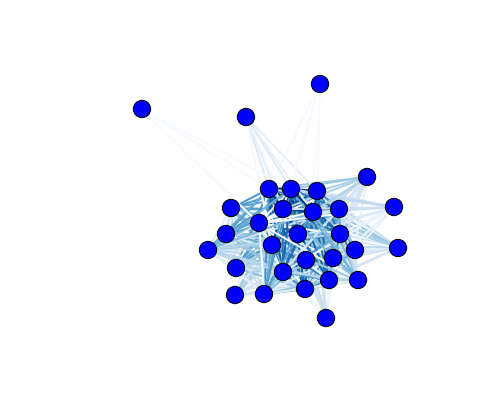

In [106]:
plt.figure(1, figsize=(6, 5))
# plt.suptitle('Learned Graph')
nx.draw(kalo_graph, node_color='b', edgelist=kalo_edges, edge_color=kalo_weights, width=2.0, edge_cmap=plt.cm.Blues)

# plt.figure(2, figsize=(10, 5))
# plt.suptitle('Uniform')
# nx.draw(uniform_graph, node_color='b', edgelist=uniform_edges, edge_color=uniform_weights, width=10.0, edge_cmap=plt.cm.Blues)

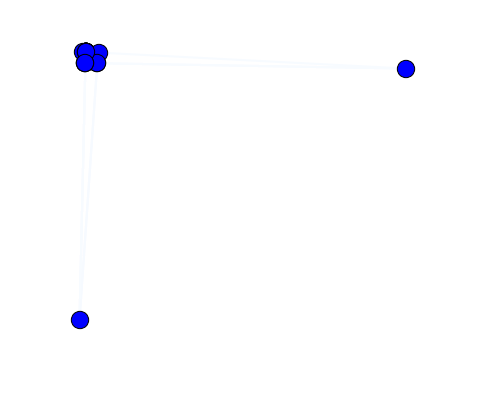

In [107]:
# communities
plt.figure(1, figsize=(6, 5))
# plt.suptitle('Kalofolias')
nx.draw_spectral(kalo_graph, node_color='b', edgelist=kalo_edges, edge_color=kalo_weights, width=2.0, edge_cmap=plt.cm.Blues)

# plt.figure(2, figsize=(6, 5))
# plt.suptitle('Uniform')
# nx.draw_spectral(uniform_graph, node_color='b', edgelist=uniform_edges, edge_color=uniform_weights, width=10.0, edge_cmap=plt.cm.Blues)

## Study with communication budget

In [ ]:
global_test_accs = []
global_com = []

for k in range(K):
    
    nodes_copy = deepcopy(nodes[:k+1])
    centralized_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
    
    global_com.append(len(nodes[k].sample))
    global_test_accs.append(central_test_accuracy(nodes_copy))

In [ ]:
from math import log

Z = 32
# test accuracy vs communication
linear_com = 2*D*Z
regularized_com = [np.sum(r['edges'])/K *(Z + log(n)) for r in results['Dada']]

x_linear = [linear_com*i for i in range(len(results['personalized linear gd']))]
x_dada = [sum(regularized_com[:i]) for i in range(NB_ITER+1)]
x_global = [sum(global_com[:i])*D*Z for i in range(K)]

plt.figure(1, figsize=(10, 6))

plt.xlabel('communication cost', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)

plt.plot(x_linear, [r['test-accuracy'] for r in results['personalized linear gd']], label='personalized linear gd', color=colors['personalized linear gd'], linewidth=2)
plt.plot(x_dada, [r['test-accuracy'] for r in results['Dada']], label='Dada', color=colors['Dada'], linewidth=2)
plt.plot(x_global, global_test_accs, label="global l1 Adaboost", color=colors["global l1 Adaboost"], linewidth=2)

plt.xlim(0, min(max(x_dada), max(x_linear), max(x_global)))
plt.ylim(0, 1)
plt.legend(loc="lower right", fontsize=18)

plt.figure(2, figsize=(10, 6))

plt.xlabel('communication cost', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)

plt.plot(x_linear, [r['test-accuracy'] for r in results['personalized linear gd']], label='personalized linear gd', color=colors['personalized linear gd'], linewidth=2)
plt.plot(x_dada, [r['test-accuracy'] for r in results['Dada']], label='Dada', color=colors['Dada'], linewidth=2)
plt.plot(x_global, global_test_accs, label="global l1 Adaboost", color=colors["global l1 Adaboost"], linewidth=2)

plt.xlim(0, max(x_global))
plt.ylim(0, 1)
plt.legend(loc="lower right", fontsize=18)

# Walking upstairs vs walking downstairs

In [2]:
# set graph of nodes with local personalized data
NB_ITER = 1000
n = 1122

MU = 10
BETA = 1

X, Y, X_test, Y_test, K, max_nb_instances = load_harws(path="../datasets/", walking=True)
D = X[0].shape[1]

# get nodes
nodes = null_graph(X, Y, X_test, Y_test, K, max_nb_instances)

# set monitors for optimization analysis
monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
#     'edges': [edges, []]
}

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D, min_v=vmin, max_v=vmax)

results = {}

In [3]:
centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["global l1 Adaboost"] = {}
results["global l1 Adaboost"]["train-accuracy"] = central_train_accuracy(centralized_nodes)
results["global l1 Adaboost"]["test-accuracy"] = central_test_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["purely local models"] = {}
results["purely local models"]["train-accuracy"] = central_train_accuracy(local_nodes)
results["purely local models"]["test-accuracy"] = central_test_accuracy(local_nodes)

In [15]:
results["personalized linear gd"], clf_colearning = alternating_colearning(K, X, Y, X_test, Y_test, D, NB_ITER, 
    mu=0.1, la=1000, pace_gd=50, max_samples_per_node=max_nb_instances, checkevery=1)

In [16]:
MU, LA = 0.001, 0.1
STEP = 50

monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
    'edges': [edges, []],
    'obj-function': [kalo_objective, [MU, LA]],
}

gd_nodes = deepcopy(nodes)

results["Dada"] = gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"kalo", "pace_gd": STEP, 
    "args":(MU, LA)}, beta=BETA, mu=MU, nb_iter=NB_ITER, monitors=monitors, checkevery=1)

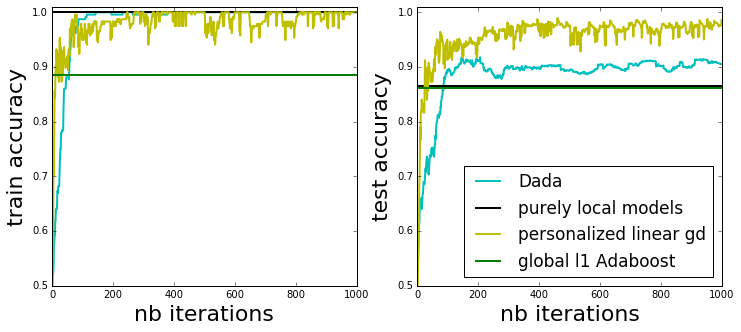

In [19]:
plt.figure(1, figsize=(12, 5))

colors = {
    "global l1 Adaboost": "g",
    "purely local models": "k",
    "personalized linear gd": "y", 
    "Dada": "c",
}

max_iter = NB_ITER
plt.subplot(121)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('train accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.5, 1.01)

for k, r_list in results.items():
    try:
        plt.plot([i for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label='_nolegend_', color=colors[k], linewidth=2)
    except:
        plt.plot(range(max_iter+1), [r_list['train-accuracy']]*(max_iter+1), label='{}'.format(k), color=colors[k], linewidth=2)
# plt.legend(loc='lower right', fontsize=17)


plt.subplot(122)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.5, 1.01)

for k, r_list in results.items():
    try:
        plt.plot([i for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label=k, color=colors[k], linewidth=2)
    except:
        plt.plot(range(max_iter+1), [r_list['test-accuracy']]*(max_iter+1), label=k, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=17)
# plt.legend(bbox_to_anchor=(1.6, 1), fontsize=18)

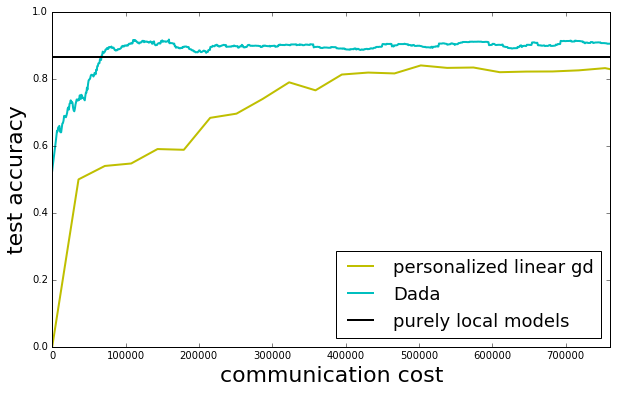

In [20]:
from math import log

Z = 32
# test accuracy vs communication
linear_com = 2*D*Z
regularized_com = [np.sum(r['edges'])/K *(Z + log(n)) for r in results['Dada']]

x_linear = [linear_com*i for i in range(len(results['personalized linear gd']))]
x_dada = [sum(regularized_com[:i]) for i in range(len(results['Dada']))]

plt.figure(1, figsize=(10, 6))

plt.xlabel('communication cost', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)

plt.plot(x_linear, [r['test-accuracy'] for r in results['personalized linear gd']], label='personalized linear gd', color=colors['personalized linear gd'], linewidth=2)
plt.plot(x_dada, [r['test-accuracy'] for r in results['Dada']], label='Dada', color=colors['Dada'], linewidth=2)
plt.plot([0, min(max(x_dada), max(x_linear))], [results["purely local models"]["test-accuracy"]]*2, label='purely local models', color=colors['purely local models'], linewidth=2)

plt.xlim(0, min(max(x_dada), max(x_linear)))
plt.ylim(0, 1)
plt.legend(loc="lower right", fontsize=18)

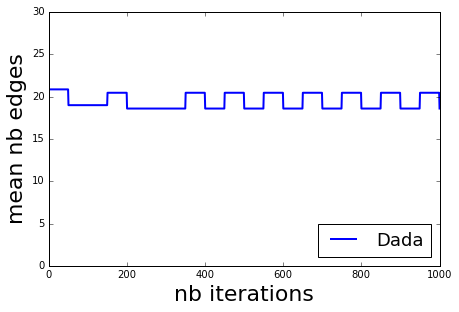

In [42]:
max_iter = NB_ITER

plt.figure(1, figsize=(7, 10))

plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('mean nb edges', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0, 30)

for k, r_list in results.items():
    try:
        plt.plot([i for i in range(len(r_list))], [np.mean(r['edges']) for r in r_list], label='{}'.format(k), linewidth=2)
    except:
        pass
    
plt.legend(loc='lower right', fontsize=18)

In [43]:
# compare graphs learned over the iterations
iterations = []

for it in range(1, 502, 50):
    nodes_first = deepcopy(nodes)
    iterations.append(gd_reg_local_FW(nodes_first, base_clfs, gd_method={"name":"kalo", "pace_gd": STEP, 
        "args":(MU, LA)}, beta=BETA, mu=MU, nb_iter=it, monitors={}))

124
20
66
68
68
68
56
152
152
12
62


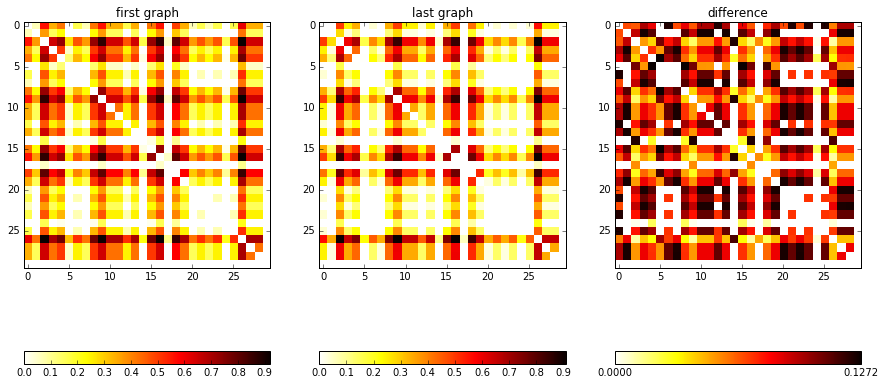

In [95]:
for it in range(len(iterations) - 1):
    print(np.sum(iterations[it][-1]["adj-matrix"] != iterations[it+1][-1]["adj-matrix"]))

print(np.sum(iterations[0][-1]["adj-matrix"] != iterations[-1][-1]["adj-matrix"]))

plt.figure(1, figsize=(15, 10))

plt.subplot(131)
plt.title("first graph")
cax = plt.imshow(iterations[0][-1]["similarities"], cmap='hot_r', interpolation='nearest')

plt.colorbar(cax, orientation='horizontal')

plt.subplot(132)
plt.title("last graph")
cax = plt.imshow(iterations[-1][-1]["similarities"], cmap='hot_r', interpolation='nearest')

plt.colorbar(cax, orientation='horizontal')

plt.subplot(133)
plt.title("difference")
diff = abs(iterations[-1][-1]["similarities"]-iterations[0][-1]["similarities"])
cax = plt.imshow(diff, cmap='hot_r', interpolation='nearest')

plt.colorbar(cax, orientation='horizontal', ticks=[0, np.max(diff)])

In [50]:
kalo_graph = nx.from_numpy_matrix(results["Dada"][-1]["adj-matrix"])
# uniform_graph = nx.from_numpy_matrix(results["Dada uniform"][-1]["adj-matrix"])

kalo_edges, kalo_weights = get_edges_weights(results["Dada"][-1]["adj-matrix"], results["Dada"][-1]["similarities"])
# uniform_edges, uniform_weights = get_edges_weights(results["Dada uniform"][-1]["adj-matrix"], results["Dada uniform"][-1]["similarities"])

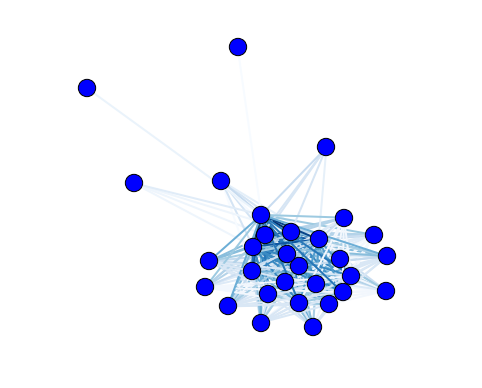

In [51]:
plt.figure(1, figsize=(6, 5))
# plt.suptitle('Learned Graph')
nx.draw(kalo_graph, node_color='b', edgelist=kalo_edges, edge_color=kalo_weights, width=2.0, edge_cmap=plt.cm.Blues)

# plt.figure(2, figsize=(10, 5))
# plt.suptitle('Uniform')
# nx.draw(uniform_graph, node_color='b', edgelist=uniform_edges, edge_color=uniform_weights, width=10.0, edge_cmap=plt.cm.Blues)

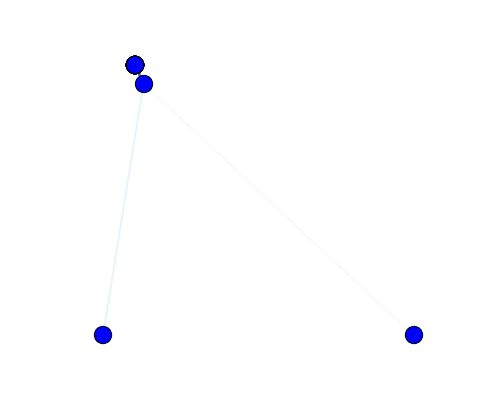

In [52]:
# communities
plt.figure(1, figsize=(6, 5))
# plt.suptitle('Kalofolias')
nx.draw_spectral(kalo_graph, node_color='b', edgelist=kalo_edges, edge_color=kalo_weights, width=2.0, edge_cmap=plt.cm.Blues)

# plt.figure(2, figsize=(6, 5))
# plt.suptitle('Uniform')
# nx.draw_spectral(uniform_graph, node_color='b', edgelist=uniform_edges, edge_color=uniform_weights, width=10.0, edge_cmap=plt.cm.Blues)

In [68]:
import itertools
LA_LIST = [j * 10**i for i in range(-5, 3) for j in range(1, 2)] + [0, 20, 40, 60, 80]
# LA_LIST = [10**i for i in range(-3, 3)]
# MU_LIST = [10**i for i in range(-3, 3)]

results_kalo = {}
# results_kalo = {}.fromkeys(itertools.product(MU_LIST, LA_LIST), {"train-accuracy": [], "test-accuracy": [], "mean-edges": []})
results_kalo = {}.fromkeys(LA_LIST, {"train-accuracy": [], "test-accuracy": [], "mean-edges": []})

NB_ITER = 500
MU = 0.001
gd_pace = 50

for la in LA_LIST:
    
#     for mu in MU_LIST:
    print(la)
    results_kalo[la] = {"train-accuracy": [], "test-accuracy": [], "mean-edges": []}
    
    for _ in range(1):
        gd_nodes = deepcopy(nodes)
        gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"kalo", "pace_gd": gd_pace, "args":(MU, la)},
                        beta=BETA, mu=MU, nb_iter=NB_ITER, monitors={})

        results_kalo[la]["train-accuracy"].append(central_train_accuracy(gd_nodes))
        results_kalo[la]["test-accuracy"].append(central_test_accuracy(gd_nodes))        
        results_kalo[la]["mean-edges"].append(np.mean(edges(gd_nodes)))

1e-05
0.0001
0.001
0.01
0.1
1
10
100
0
20
40
60
80


In [69]:
# avg results by lambda
keys = []

for la in LA_LIST:
    try:
        keys += results_kalo[la]["mean-edges"]
    except:
        keys.append(results_kalo[la]["mean-edges"])

keys = set(keys)

# sort results
train = {k: list() for k in keys}
test = {k: list() for k in keys}

for la, value in results_kalo.items():

    for e, tr, te in zip(value["mean-edges"], value["train-accuracy"], value["test-accuracy"]):
        train[e].append(tr)
        test[e].append(te)

sorted_keys = sorted(keys) 

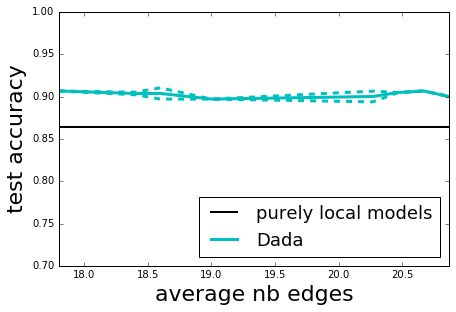

In [70]:
import operator
plt.figure(1, figsize=(7, 10))

# plt.subplot(211)
# plt.xlabel('mean nb edges', fontsize=22)
# plt.ylabel('train accuracy', fontsize=22)


# y = [np.mean(train[k]) for k in sorted_keys]
# std = [np.std(train[k]) for k in sorted_keys]

# plt.plot([0,K], [results['purely local models']['train-accuracy']]*2, label='purely local models', linewidth=2)
# plt.plot(sorted_keys, y, label='Dada', linewidth=3, color="c")
# plt.plot(sorted_keys, list(map(operator.sub, y, std)), '--', linewidth=3, color="c")
# plt.plot(sorted_keys, list(map(operator.add, y, std)), '--', linewidth=3, color="c")
# # plt.scatter([value[] for k, value in results_kalo.items()], [], linewidth=1)
# plt.xlim(min(sorted_keys), max(sorted_keys))
# plt.ylim(0.7, 1)

# plt.legend(loc='center right', fontsize=18)

plt.subplot(212)
plt.xlabel('average nb edges', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)

y = [np.mean(test[k]) for k in sorted_keys]
std = [np.std(test[k]) for k in sorted_keys]
# print(y, sorted_keys)
plt.plot([0, K], [results['purely local models']['test-accuracy']]*2, label='purely local models', linewidth=2, color='k')
plt.plot(sorted_keys, y, label='Dada', linewidth=3, color='c')
plt.plot(sorted_keys, list(map(operator.sub, y, std)), '--', linewidth=3, color="c")
plt.plot(sorted_keys, list(map(operator.add, y, std)), '--', linewidth=3, color="c")

plt.xlim(min(sorted_keys), max(sorted_keys))
plt.ylim(0.7, 1)

plt.legend(loc='lower right', fontsize=18)

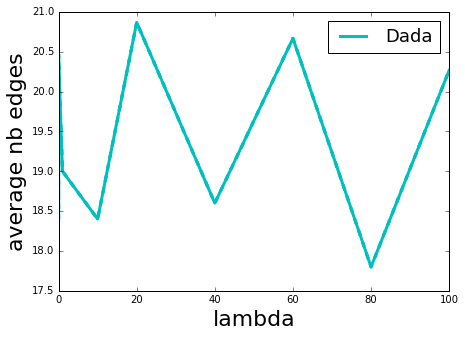

In [73]:
plt.figure(1, figsize=(7, 5))

plt.xlabel('lambda', fontsize=22)
plt.ylabel('average nb edges', fontsize=22)

sorted_la_list = sorted(LA_LIST)

y = [np.mean(results_kalo[la]["mean-edges"]) for la in sorted_la_list]
std = [np.std(results_kalo[la]["mean-edges"]) for la in sorted_la_list]
plt.plot(sorted_la_list, y, label='Dada', linewidth=3, color="c")
plt.plot(sorted_la_list, list(map(operator.sub, y, std)), '--', linewidth=3, color="c")
plt.plot(sorted_la_list, list(map(operator.add, y, std)), '--', linewidth=3, color="c")

plt.legend(loc='upper right', fontsize=18)